In [2]:
import numpy as np
import pandas as pd
import os
myData = '/content/drive/MyDrive/NSU_Courses/CSE/CSE499A';
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir(myData))

Mounted at /content/drive
['cc.bn.300.vec', 'glove.840B.300d.txt', 'crawl-300d-2M.vec', 'class recordings', 'test.xlsx', 'CSE499A Papers', 'trainv1.xlsx', 'cuet_dataset.xlsx', 'cuet_dataset.csv', 'train.csv', 'test.csv']


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
pd.set_option('max_colwidth',400)

In [4]:
train = pd.read_csv(myData+'/train.csv')
test = pd.read_csv(myData+'/test.csv')
train.head()

,Unnamed: 0,cleaned,classes,labels
0,0,মেডিকেলে এসে ঠিক ফ্যামিলির ফটো ফ্রেম এর মতো মনে হতো নিজেকেখাপছাড়া লাগতোদম বন্ধ হয়ে আসতোঅন্যদের সামনে অপমানিত হতে হতো পদে পদে,sadness,1
1,1,অনেক দিন পর অন্য রকম অনুভূতি হচ্ছে কেননা আমার সদ্য পাশ করা শিক্ষার্থীর মত এখন আমিও বেকার বেকার পরিচয় দিয়ে আম্মার কাছ থেকে আজ পঞ্চাশ টাকা ডাকাতি করলাম,sadness,1
2,2,আগে যতোটা বেশি পছন্দ করতাম দুশ্চরিত্রা মিথিলা মুখার্জি কে এখন তেমনি সবচেয়ে বেশি ঘৃণা করি ওই পতিতা সদ্য হিন্দু হওয়া মিথিলা মুখার্জি কে,disgust,3
3,3,মাঝে মাঝে মনে হয় তোমাকে চাওয়াটা অনেক ভুল হয়ত ভুল তবে এই ভুলের মাশুল এইভাবেই কি দিতে হতো জানি না তবে যা জানি তা মানি না,sadness,1
4,4,এখানে কাওকে কবর দিয়ো না তাহলে তোমাদের পরিবারের আর কেউ বেঁচে থাকবে না ও তোমাদের কাউকে বাঁচতে দিবে না চলে যাও এখান থেকে নিজে থেকে অভিশাপকে আহ্বান করো না,fear,5


In [5]:
test.head()

,Unnamed: 0,cleaned,classes,labels
0,0,দুই বছরের ব্যবধানে বগুড়া থেকে বিদেশে পণ্য রপ্তানি সাত গুণ বেড়েছে গত বছর বগুড়া থেকে ভারত ও নেপালে পণ্য রপ্তানি করে আয় হয়েছে ৭ কোটি ২৩ লাখ ৩০ হাজার ৬৩২ মার্কিন ডলার বাংলাদেশি মুদ্রায় রপ্তানি আয়ের পরিমাণ ৬০৭ কোটি ৫৭ লাখ ৭৩ হাজার ৮৮ টাকা,joy,0
1,1,আওয়ামী লীগ সরকার বাংলাদেশকে অন্ধকার কুয়া থেকে টেনে আলোর পথে এনেছে বলে মন্তব্য করেছেন পরিকল্পনামন্ত্রী এম এ মান্নান তিনি বলেছেন মাথা নুয়ে থাকার দিন শেষ শেখ হাসিনার নেতৃত্বে বাংলাদেশ এখন বিশ্বে মর্যাদার আসনে রয়েছে,joy,0
2,2,চোখ কচলাতে কচলাতে বেশ রাগান্বীত কন্ঠ বলল ধুরো মরা ঘুমাইয়াও শান্তি নাই এত রাইতে মরতে কই যাইবেন,disgust,3
3,3,মেয়েটা অতিরিক্ত আত্মপরিচয় সংকটে ভুগে সাবিলা স্যাবলাই রয়ে গেলো বিউটি উইথআউট ব্রেইন,disgust,3
4,4,এবার উন্নয়ন মুলক কাজের কিছু দৃশ্যমান পরিদশন করবেন বাংলাদেশ স্কাউটের ছেলে মেয়েরা বঙ্গবন্ধু শেখ মুজিবুর রহমান শিল্প নগর মিরসরাই চটগ্রামআয়োজনে বেজা অথরিটি মাচ মাসে এটা নিজের চোখে না দেখলে কখনো বিস্বাস করা যাবে না বর্তমান সরকার কি করতে চলেছে এককথায় অসাধারন একটি পরিকল্পনা ধন্যবাদ,joy,0


In [6]:
print('Number of sentences in train: {}.'.format(train.shape[0]))
print('Number of sentences in test: {}.'.format(test.shape[0]))

Number of sentences in train: 5618.
Number of sentences in test: 625.


In [7]:
train["classes"].value_counts()

disgust     1388
sadness     1071
joy         1028
fear         789
anger        688
surprise     654
Name: classes, dtype: int64

In [8]:
test["classes"].value_counts()

disgust     165
sadness     119
joy         114
fear         83
surprise     73
anger        71
Name: classes, dtype: int64

In [9]:
#checking for null values
train.info()
print()
test.info()
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5618 entries, 0 to 5617
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5618 non-null   int64 
 1   cleaned     5618 non-null   object
 2   classes     5618 non-null   object
 3   labels      5618 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 175.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625 entries, 0 to 624
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  625 non-null    int64 
 1   cleaned     625 non-null    object
 2   classes     625 non-null    object
 3   labels      625 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 19.7+ KB



In [10]:
tokenizer = TweetTokenizer()

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(train['cleaned'].values) + list(test['cleaned'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['cleaned'])
test_vectorized = vectorizer.transform(test['cleaned'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [12]:
y = train['labels']

In [13]:
logreg = LogisticRegression()
ovr = OneVsRestClassifier(logreg)

In [14]:
%%time
ovr.fit(train_vectorized, y)

CPU times: user 4.18 s, sys: 5.08 s, total: 9.26 s
Wall time: 7.09 s


OneVsRestClassifier(estimator=LogisticRegression())

In [15]:
scores = cross_val_score(ovr, train_vectorized, y, scoring='accuracy', n_jobs=-1, cv=3)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 55.91%, std 0.51.


In [16]:
%%time
svc = LinearSVC(dual=False)
scores = cross_val_score(svc, train_vectorized, y, scoring='accuracy', n_jobs=-1, cv=3)
print('Cross-validation mean accuracy {0:.2f}%, std {1:.2f}.'.format(np.mean(scores) * 100, np.std(scores) * 100))

Cross-validation mean accuracy 59.52%, std 0.97.
CPU times: user 34.8 ms, sys: 6.98 ms, total: 41.8 ms
Wall time: 1.81 s


In [17]:
ovr.fit(train_vectorized, y)
svc.fit(train_vectorized, y)

LinearSVC(dual=False)

In [45]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU 
from keras.layers import CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.layers import InputSpec, Layer
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [19]:
tk = Tokenizer(lower = True, filters = '')
tk.fit_on_texts(full_text)

In [20]:
train_tokenized = tk.texts_to_sequences(train['cleaned'])
test_tokenized = tk.texts_to_sequences(test['cleaned'])

In [21]:
#calculating max length of the vector
lens_train = [len(i) for i in train_tokenized]
lens_test = [len(i) for i in test_tokenized]
lens = lens_train + lens_test

max_len = np.max(lens)

print('Max len:', max_len)

Max len: 215


In [22]:
#Zero padding
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [23]:
embedding_path = myData+"/crawl-300d-2M.vec"

In [24]:
embed_size = 300
max_features = 30000

In [25]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [26]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))

In [27]:
#Model 1
def build_model1(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, 
                 dense_units=128, dr=0.0,conv_size=32):
    file_path = "model_1.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)
    
    inp = Input(shape = (max_len,))
    x = Embedding(26277, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(6, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [28]:
model1 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 64, spatial_dr = 0.3, kernel_size1=3, 
                      kernel_size2=2, dense_units=32, dr=0.1, conv_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.7494 - accuracy: 0.1968
Epoch 00001: val_loss improved from inf to 0.64374, saving model to model_1.hdf5
40/40 [==============================] - 23s 214ms/step - loss: 0.7494 - accuracy: 0.1968 - val_loss: 0.6437 - val_accuracy: 0.2616
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6078 - accuracy: 0.2253
Epoch 00002: val_loss improved from 0.64374 to 0.53983, saving model to model_1.hdf5
40/40 [==============================] - 7s 177ms/step - loss: 0.6078 - accuracy: 0.2253 - val_loss: 0.5398 - val_accuracy: 0.2633
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.2271
Epoch 00003: val_loss improved from 0.53983 to 0.47211, saving model to model_1.hdf5
40/40 [==============================] - 7s 176ms/step - loss: 0.5377 - accuracy: 0.2271 - val_loss: 0.4721 - val_accuracy: 0.2669
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.491

In [29]:
model2 = build_model1(lr = 1e-3, lr_d = 1e-10, units = 128, 
                      spatial_dr = 0.5, kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.2, conv_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.1865
Epoch 00001: val_loss improved from inf to 0.51495, saving model to model_1.hdf5
40/40 [==============================] - 18s 276ms/step - loss: 0.6857 - accuracy: 0.1865 - val_loss: 0.5150 - val_accuracy: 0.2242
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.5273 - accuracy: 0.2027
Epoch 00002: val_loss improved from 0.51495 to 0.46021, saving model to model_1.hdf5
40/40 [==============================] - 10s 247ms/step - loss: 0.5273 - accuracy: 0.2027 - val_loss: 0.4602 - val_accuracy: 0.2633
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.4881 - accuracy: 0.2098
Epoch 00003: val_loss improved from 0.46021 to 0.45521, saving model to model_1.hdf5
40/40 [==============================] - 10s 254ms/step - loss: 0.4881 - accuracy: 0.2098 - val_loss: 0.4552 - val_accuracy: 0.2598
Epoch 4/20
40/40 [==============================] - ETA: 0s - loss: 0.4

In [32]:
def build_model2(lr=0.0, lr_d=0.0, units=0, spatial_dr=0.0, kernel_size1=3, kernel_size2=2, dense_units=128, dr=0.1, conv_size=32):
    file_path = "best_model.hdf5"
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                                  save_best_only = True, mode = "min")
    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

    inp = Input(shape = (max_len,))
    x = Embedding(26277, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(spatial_dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    
    x_conv1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x_conv1)
    max_pool1_gru = GlobalMaxPooling1D()(x_conv1)
    
    x_conv2 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool2_gru = GlobalAveragePooling1D()(x_conv2)
    max_pool2_gru = GlobalMaxPooling1D()(x_conv2)
    
    
    x_conv3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x_conv3)
    max_pool1_lstm = GlobalMaxPooling1D()(x_conv3)
    
    x_conv4 = Conv1D(conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool2_lstm = GlobalAveragePooling1D()(x_conv4)
    max_pool2_lstm = GlobalMaxPooling1D()(x_conv4)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool2_gru, max_pool2_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool2_lstm, max_pool2_lstm])
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(dense_units, activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(dr)(Dense(int(dense_units / 2), activation='relu') (x))
    x = Dense(6, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [33]:
model3 = build_model2(lr = 1e-4, lr_d = 0, units = 64, spatial_dr = 0.5, kernel_size1=4, 
                      kernel_size2=3, dense_units=32, dr=0.1, conv_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.1873
Epoch 00001: val_loss improved from inf to 0.68029, saving model to best_model.hdf5
40/40 [==============================] - 14s 212ms/step - loss: 0.7230 - accuracy: 0.1873 - val_loss: 0.6803 - val_accuracy: 0.1744
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.1812
Epoch 00002: val_loss improved from 0.68029 to 0.66347, saving model to best_model.hdf5
40/40 [==============================] - 7s 187ms/step - loss: 0.6831 - accuracy: 0.1812 - val_loss: 0.6635 - val_accuracy: 0.1477
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.1818
Epoch 00003: val_loss improved from 0.66347 to 0.64404, saving model to best_model.hdf5
40/40 [==============================] - 7s 187ms/step - loss: 0.6516 - accuracy: 0.1818 - val_loss: 0.6440 - val_accuracy: 0.1459
Epoch 4/20
40/40 [==============================] - ETA: 0s - lo

In [34]:
model4 = build_model2(lr = 1e-3, lr_d = 0, units = 64, spatial_dr = 0.5, 
                      kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.3, conv_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.1861
Epoch 00001: val_loss improved from inf to 0.55840, saving model to best_model.hdf5
40/40 [==============================] - 13s 205ms/step - loss: 0.6376 - accuracy: 0.1861 - val_loss: 0.5584 - val_accuracy: 0.2456
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.1956
Epoch 00002: val_loss improved from 0.55840 to 0.48765, saving model to best_model.hdf5
40/40 [==============================] - 7s 185ms/step - loss: 0.5221 - accuracy: 0.1956 - val_loss: 0.4876 - val_accuracy: 0.2562
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.2189
Epoch 00003: val_loss improved from 0.48765 to 0.45839, saving model to best_model.hdf5
40/40 [==============================] - 7s 185ms/step - loss: 0.4949 - accuracy: 0.2189 - val_loss: 0.4584 - val_accuracy: 0.2722
Epoch 4/20
40/40 [==============================] - ETA: 0s - lo

In [35]:
model5 = build_model2(lr = 1e-3, lr_d = 1e-7, units = 64, spatial_dr = 0.3, 
                      kernel_size1=3, kernel_size2=3, dense_units=64, dr=0.4, conv_size=64)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.1729
Epoch 00001: val_loss improved from inf to 0.55417, saving model to best_model.hdf5
40/40 [==============================] - 14s 217ms/step - loss: 0.7412 - accuracy: 0.1729 - val_loss: 0.5542 - val_accuracy: 0.2349
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.1905
Epoch 00002: val_loss improved from 0.55417 to 0.51879, saving model to best_model.hdf5
40/40 [==============================] - 8s 192ms/step - loss: 0.5832 - accuracy: 0.1905 - val_loss: 0.5188 - val_accuracy: 0.1904
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.2019
Epoch 00003: val_loss improved from 0.51879 to 0.47230, saving model to best_model.hdf5
40/40 [==============================] - 8s 191ms/step - loss: 0.5256 - accuracy: 0.2019 - val_loss: 0.4723 - val_accuracy: 0.2242
Epoch 4/20
40/40 [==============================] - ETA: 0s - lo

In [36]:
pred1 = model1.predict(X_test, batch_size = 1024, verbose = 1)
pred = pred1
pred2 = model2.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred2
pred3 = model3.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred3
pred4 = model4.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred4
pred5 = model5.predict(X_test, batch_size = 1024, verbose = 1)
pred += pred5

1/1 [==============================] - 1s 882ms/step


In [46]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [47]:
def build_model(maxlen, max_features, embed_size, embedding_matrix):
    input_words = Input((max_len, ))
    x_words = Embedding(26277,
                        embed_size,
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False)(input_words)
    x_words = SpatialDropout1D(0.2)(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    
    x = Attention(maxlen)(x_words)
    #x = GlobalMaxPooling1D()(x)
    #x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(6, activation='softmax')(x)

    model = Model(inputs=input_words, outputs=pred)
    return model

model = build_model(max_len, max_features, embed_size, embedding_matrix)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 215)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 215, 300)          7883100   
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 215, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_16 (Bidirecti  (None, 215, 256)         439296    
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 215, 256)         394240    
 onal)                                                           
                                                           

In [48]:
def build_model(maxlen, max_features, embed_size, embedding_matrix):
    input_words = Input((max_len, ))
    x_words = Embedding(26277,
                        embed_size,
                        weights=[embedding_matrix],
                        mask_zero=True,
                        trainable=False)(input_words)
    x_words = SpatialDropout1D(0.2)(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    x_words = Bidirectional(LSTM(128, return_sequences=True))(x_words)
    
    x = Attention(maxlen)(x_words)
    #x = GlobalMaxPooling1D()(x)
    #x = GlobalAveragePooling1D()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    pred = Dense(6, activation='softmax')(x)

    model = Model(inputs=input_words, outputs=pred)
    return model

model = build_model(max_len, max_features, embed_size, embedding_matrix)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 215)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 215, 300)          7883100   
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 215, 300)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_18 (Bidirecti  (None, 215, 256)         439296    
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 215, 256)         394240    
 onal)                                                           
                                                           

In [49]:
save_file = 'model_CNN_BiLSTM_Attention_BEmoD.h5'
#history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 20, validation_split=0.2, 
                        #verbose = 1, callbacks = [check_point, early_stop])
history = model.fit(X_train, y_ohe,
                    epochs=20, verbose=1,
                    batch_size=512, shuffle=True)

Epoch 1/20
11/11 [==============================] - 59s 3s/step - loss: 0.5433 - accuracy: 0.1938
Epoch 2/20
11/11 [==============================] - 40s 4s/step - loss: 0.4682 - accuracy: 0.2141
Epoch 3/20
11/11 [==============================] - 38s 3s/step - loss: 0.4576 - accuracy: 0.2232
Epoch 4/20
11/11 [==============================] - 38s 3s/step - loss: 0.4541 - accuracy: 0.2273
Epoch 5/20
11/11 [==============================] - 37s 3s/step - loss: 0.4510 - accuracy: 0.2348
Epoch 6/20
11/11 [==============================] - 38s 3s/step - loss: 0.4509 - accuracy: 0.2326
Epoch 7/20
11/11 [==============================] - 37s 3s/step - loss: 0.4488 - accuracy: 0.2417
Epoch 8/20
11/11 [==============================] - 36s 3s/step - loss: 0.4466 - accuracy: 0.2471
Epoch 9/20
11/11 [==============================] - 36s 3s/step - loss: 0.4445 - accuracy: 0.2634
Epoch 10/20
11/11 [==============================] - 36s 3s/step - loss: 0.4420 - accuracy: 0.2706
Epoch 11/20
11/11 [

In [50]:
pred = model.predict(X_test, batch_size = 1024, verbose = 1)

1/1 [==============================] - 9s 9s/step


In [53]:
def PlotGraph(history):
    acc = history.history['accuracy']
    #val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
   # plt.plot(x, val_acc, 'b', label='Validation acc')
   # plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
   # plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

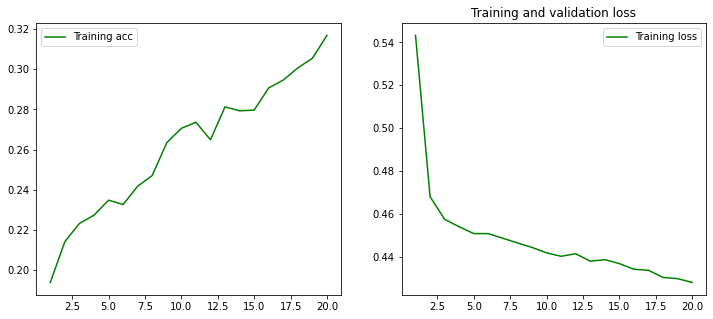

In [54]:
PlotGraph(history)

In [55]:
print(f"Best Accuracy Achieved by Model: {max(history.history['accuracy'])}")

Best Accuracy Achieved by Model: 0.31683874130249023


In [68]:
pred_probabilities = model.predict(X_test)

In [69]:
pred_probabilities

array([[0.24348253, 0.28289288, 0.1974156 , 0.07767271, 0.09359638,
        0.10493986],
       [0.42548427, 0.19832939, 0.17534554, 0.06687133, 0.0673522 ,
        0.06661738],
       [0.19253345, 0.18087788, 0.11479597, 0.22133149, 0.10125295,
        0.18920822],
       ...,
       [0.20789012, 0.16484736, 0.10860516, 0.22253948, 0.08948753,
        0.20663036],
       [0.15155563, 0.2964909 , 0.15513547, 0.11650542, 0.10126229,
        0.17905031],
       [0.06949627, 0.45593363, 0.10828914, 0.13908653, 0.09650256,
        0.13069192]], dtype=float32)

In [71]:
from sklearn.metrics import classification_report,confusion_matrix

In [75]:
from sklearn.metrics import classification_report

print(classification_report(X_test["labels"], pred_probabilities, target_names =["anger", "fear", "joy", "disgust", "sadness", "surprise"]))

IndexError: ignored